In [1]:
import dask
import dask.dataframe as dd
import pandas as pd

## Exploring OpenFoodFacts CSV
Source : https://fr.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv

In [2]:
ddf_OFF = dd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t", encoding="utf-8", low_memory=False,
                  #usecols=["code", "url", "quantity", "product_name", "categories_tags", "countries_tags", "ingredients_text", "states_tags", "main_category"],
                  usecols=["code", "product_name", "categories_tags", "main_category"],
                  dtype={'allergens': 'object',
       'cities_tags': 'object',
       'emb_codes': 'object',
       'emb_codes_tags': 'object',
       'first_packaging_code_geo': 'object',
       'generic_name': 'object',
       'ingredients_from_palm_oil_tags': 'object',
       'labels': 'object',
       'labels_fr': 'object',
       'labels_tags': 'object',
       'manufacturing_places': 'object',
       'manufacturing_places_tags': 'object',
       'origins': 'object',
       'origins_tags': 'object',
       'stores': 'object',
       'code': 'object','allergens_fr': 'object',
       'cities': 'object',
       'created_t': 'object',
       'last_modified_t': 'object',
       'serving_quantity':'object'})
ddf_OFF.head()

,code,product_name,categories_tags,main_category
0,0000000000017,Vitória crackers,NaN,NaN
1,0000000000031,Cacao,NaN,NaN
2,0000000000123,Sauce Sweety chili 0%,NaN,NaN
3,0000000000291,Mendiants,NaN,NaN
4,0000000000949,Salade de carottes râpées,NaN,NaN


## Exploring Phenix SQL database

Connection via SQL Express en local

In [3]:
import pyodbc
con = pyodbc.connect(Trusted_Connection='yes', driver = '{SQL Server}',server = 'localhost\SQLEXPRESS' , database = 'PHX_D4G')

Envoie de la query SQL --> Dataframe

`where CategorieProduits.Id<=5;` --> filtre les aliments seulement

In [4]:
sql = """select Produits.Ean,Produits.Nom,CategorieProduits.Nom \n
    from Produits \n
    inner join CategorieProduits on Produits.Categorie_CategorieProduit_Id=CategorieProduits.Id \n
    where CategorieProduits.Id<=5;"""
df_Phenix = pd.read_sql(sql,con)
df_Phenix.head()

,Ean,Nom,Nom
0,3266742120681,CHINOIS ROND CHOCOLAT,"Fruits, légumes, boulangerie"
1,3266742120711,TRESSE PEPITES CHOCOLAT,"Fruits, légumes, boulangerie"
2,3266742120780,TRESSE NATURE,"Fruits, légumes, boulangerie"
3,3266742120995,TRESSE PRALINE 500G,"Fruits, légumes, boulangerie"
4,3266742120858,VIENNOIS.PEPITES CHOCO X4,"Fruits, légumes, boulangerie"


Préparation pour le merge avec la DB OpenFoodFacts 
* Changement du nom de colonne EAN
* Suppression des duplicats dans les produits PHENIX

In [5]:
df_Phenix = df_Phenix.rename(columns = {'Ean':'code'})

phenix_nb_products = df_Phenix.shape[0]
df_Phenix.columns = ['code','Nom','categorie']
df_Phenix_unique = df_Phenix.drop_duplicates()
phenix_nb_products_unique = df_Phenix_unique.shape[0]

print(str(phenix_nb_products) + ' produits dans la DB Phénix')
print(str(phenix_nb_products_unique) + ' produits uniques')

573013 produits dans la DB Phénix
322191 produits uniques


Merge de DB produits uniques de Phenix et DB OpenFoodFacts
* Merge des DB
* Renommer les colonnes pour la présentation
* Extraction en CSV, si nécessaire `df_OFF_et_Phenix.to_csv('comparisonDB_OFF_vs_PHENIX.csv')`

In [6]:
df_OFF_et_Phenix = pd.merge(ddf_OFF.compute(), df_Phenix_unique, on=['code'], how='right')
df_OFF_et_Phenix.columns = ['EAN','OFF_product_name','OFF_categories_tags','OFF_main_category','PHENIX_Nom','PHENIX_categorie']
#df_OFF_et_Phenix.to_csv('comparisonDB_OFF_vs_PHENIX.csv')

## Analyse des données de Catégorie

In [7]:
df_OFF_et_Phenix.head()

,EAN,OFF_product_name,OFF_categories_tags,OFF_main_category,PHENIX_Nom,PHENIX_categorie
0,0000000000031,Cacao,NaN,NaN,ESCALOPE DE DINDE,"Boucherie, volailles, poissonnerie, charcuterie"
1,0000000000123,Sauce Sweety chili 0%,NaN,NaN,CONSERVES DE POISSONS,"Epicerie salée, sucrée et boissons"
2,0000000000123,Sauce Sweety chili 0%,NaN,NaN,PMK FRUITS CASSE,"Fruits, légumes, boulangerie"
3,0000000000123,Sauce Sweety chili 0%,NaN,NaN,ARTICHAUT CALICO CAL 15,"Epicerie salée, sucrée et boissons"
4,0000000001137,Baguette parisien,NaN,NaN,MELON VERT,"Fruits, légumes, boulangerie"


In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt

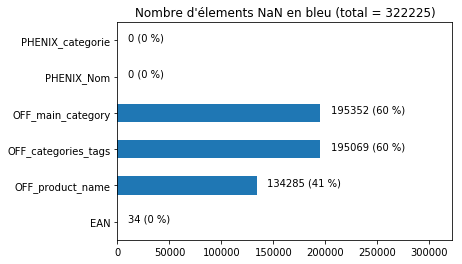

In [9]:
df_countNA = df_OFF_et_Phenix.isnull().sum()
total_elements = df_OFF_et_Phenix.shape[0]
titre = "Nombre d'élements NaN en bleu (total = " + str(total_elements) + ")"

fig = plt.figure()
ax = fig.add_subplot(111)
df_countNA.plot.barh(xlim =[0,total_elements], title=titre)

a = 0
for i,j in df_countNA.items():
    s = str(j) + ' ('+ str(int(j/total_elements*100)) + ' %)'
    ax.annotate(s, xy=(j+10000, a))
    a = a +1

### Résultats de l'analyse
* __322 225 produits alimentaires uniques__ dans Phénix
* __41%__ des produits dans Phénix ne sont pas dans la DB de OpenFoodFacts.
* __34__ produits Phénix n'ont pas de code EAN
* __Attention__ il y a également des produits Phénix qui sont mal référencés par le code EAN
* __60%__ des produits dans Phénix n'ont pas de catégorie DB.

Il faudra imaginer une solution pour:
* trier les produits Phénix qui sont mal référencés
* catégoriser les produits par groupe alimentaire (dictionaire de mots clés? Machine Learning?)
* associer une qualité nutritive (aide de nutritioniste?)
* valider la quantité des dons reçus

In [10]:
h = df_OFF_et_Phenix.OFF_main_category.value_counts()
#h.to_csv('OFF_Categories_to_FoodGroups.csv')